# 9. [Getting Data 取得數據資料](https://github.com/joelgrus/data-science-from-scratch/blob/master/code/getting_data.py)

In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [30]:
from __future__ import division
from collections import Counter
import math, random, csv, json
import re

from bs4 import BeautifulSoup
import requests

######
#
# BOOKS ABOUT DATA
#
######

def is_video(td):
    """it's a video if it has exactly one pricelabel, and if
    the stripped text inside that pricelabel starts with 'Video'"""
    pricelabels = td('span', 'pricelabel')
    return (len(pricelabels) == 1 and
            pricelabels[0].text.strip().startswith("Video"))

def book_info(td):
    """given a BeautifulSoup <td> Tag representing a book,
    extract the book's details and return a dict"""
    
    title = td.find("div", "thumbheader").a.text
    by_author = td.find('div', 'AuthorName').text
    authors = [x.strip() for x in re.sub("^By ", "", by_author).split(",")]
    isbn_link = td.find("div", "thumbheader").a.get("href")
    isbn = re.match("/product/(.*)\.do", isbn_link).groups()[0]
    date = td.find("span", "directorydate").text.strip()
    
    return {
        "title" : title,
        "authors" : authors,
        "isbn" : isbn,
        "date" : date
    }

from time import sleep

def scrape(num_pages=31):
    base_url = "http://shop.oreilly.com/category/browse-subjects/" + \
           "data.do?sortby=publicationDate&page="

    books = []

    for page_num in range(1, num_pages + 1):
        print("souping page", page_num)
        url = base_url + str(page_num)
        soup = BeautifulSoup(requests.get(url).text, 'html5lib')
            
        for td in soup('td', 'thumbtext'):
            if not is_video(td):
                books.append(book_info(td))

        # now be a good citizen and respect the robots.txt!
        sleep(3)

    return books

def get_year(book):
    """book["date"] looks like 'November 2014' so we need to 
    split on the space and then take the second piece"""
    return int(book["date"].split()[1])

def plot_years(plt, books):
    # 2014 is the last complete year of data (when I ran this)
    year_counts = Counter(get_year(book) for book in books
                          if get_year(book) <= 2024)

    years = sorted(year_counts)
    book_counts = [year_counts[year] for year in years]
    plt.bar([x - 0.5 for x in years], book_counts)
    plt.xlabel("year")
    plt.ylabel("# of data books")
    plt.title("Data is Big!")
    plt.show()

##
# 
# APIs
#
##

endpoint = "https://api.github.com/users/joelgrus/repos"

repos = json.loads(requests.get(endpoint).text)

from dateutil.parser import parse

dates = [parse(repo["created_at"]) for repo in repos]
month_counts = Counter(date.month for date in dates)
weekday_counts = Counter(date.weekday() for date in dates)

####
#
# Twitter
#
####

# from twython import Twython

# # fill these in if you want to use the code
# CONSUMER_KEY = ""
# CONSUMER_SECRET = ""
# ACCESS_TOKEN = ""
# ACCESS_TOKEN_SECRET = ""

# def call_twitter_search_api():

#     twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET)

#     # search for tweets containing the phrase "data science"
#     for status in twitter.search(q='"data science"')["statuses"]:
#         user = status["user"]["screen_name"].encode('utf-8')
#         text = status["text"].encode('utf-8')
#         print(user, ":", text)
#         print

# from twython import TwythonStreamer

# # appending data to a global variable is pretty poor form
# # but it makes the example much simpler
# tweets = [] 

# class MyStreamer(TwythonStreamer):
#     """our own subclass of TwythonStreamer that specifies
#     how to interact with the stream"""

#     def on_success(self, data):
#         """what do we do when twitter sends us data?
#         here data will be a Python object representing a tweet"""

#         # only want to collect English-language tweets
#         if data['lang'] == 'en':
#             tweets.append(data)

#         # stop when we've collected enough
#         if len(tweets) >= 1000:
#             self.disconnect()

#     def on_error(self, status_code, data):
#         print(status_code, data)
#         self.disconnect()

# def call_twitter_streaming_api():
#     stream = MyStreamer(CONSUMER_KEY, CONSUMER_SECRET, 
#                         ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

#     # starts consuming public statuses that contain the keyword 'data'
#     stream.statuses.filter(track='data')
    

if __name__ == "__main__":

    def process(date, symbol, price):
        print(date, symbol, price)

    print("tab delimited stock prices:")

    with open('tab_delimited_stock_prices.txt', 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            date = row[0]
            symbol = row[1]
            closing_price = float(row[2])
            process(date, symbol, closing_price)

    print

    print("colon delimited stock prices:")

    with open('colon_delimited_stock_prices.txt', 'r') as f:
        reader = csv.DictReader(f, delimiter=':')
        for row in reader:
            date = row["date"]
            symbol = row["symbol"]
            closing_price = float(row["closing_price"])
            process(date, symbol, closing_price)

    print

    print("writing out comma_delimited_stock_prices.txt")

    today_prices = { 'AAPL' : 90.91, 'MSFT' : 41.68, 'FB' : 64.5 }

    with open('comma_delimited_stock_prices.txt','w') as f:
        writer = csv.writer(f, delimiter=',')
        for stock, price in today_prices.items():
            writer.writerow([stock, price])

    print("BeautifulSoup")
    html = requests.get("http://www.example.com").text
    soup = BeautifulSoup(html, 'html5lib')
    print(soup)
    print

    print("parsing json")

    serialized = """{ "title" : "Data Science Book",
                      "author" : "Joel Grus",
                      "publicationYear" : 2014,
                      "topics" : [ "data", "science", "data science"] }"""

    # parse the JSON to create a Python object
    deserialized = json.loads(serialized)
    if "data science" in deserialized["topics"]:
        print(deserialized )

    print

    print("GitHub API")
    print("dates", dates)
    print("month_counts", month_counts)
    print("weekday_count", weekday_counts)

    last_5_repositories = sorted(repos,
                                 key=lambda r: r["created_at"],
                                 reverse=True)[:5]

    print("last five languages", [repo["language"] 
                                  for repo in last_5_repositories])

tab delimited stock prices:
6/20/2014 AAPL 90.91
6/20/2014 MSFT 41.68
6/20/2014 FB 64.5
6/19/2014 AAPL 91.86
6/19/2014 MSFT 41.51
6/19/2014 FB 64.34
colon delimited stock prices:
6/20/2014 AAPL 90.91
6/20/2014 MSFT 41.68
6/20/2014 FB 64.5
writing out comma_delimited_stock_prices.txt
BeautifulSoup
<!DOCTYPE html>
<html><head>
    <title>Example Domain</title>

    <meta charset="utf-8"/>
    <meta content="text/html; charset=utf-8" http-equiv="Content-type"/>
    <meta content="width=device-width, initial-scale=1" name="viewport"/>
    <style type="text/css">
    body {
        background-color: #f0f0f2;
        margin: 0;
        padding: 0;
        font-family: "Open Sans", "Helvetica Neue", Helvetica, Arial, sans-serif;
        
    }
    div {
        width: 600px;
        margin: 5em auto;
        padding: 50px;
        background-color: #fff;
        border-radius: 1em;
    }
    a:link, a:visited {
        color: #38488f;
        text-decoration: none;
    }
    @media (max-width

In [34]:
books = scrape()

souping page 1
souping page 2
souping page 3
souping page 4
souping page 5
souping page 6
souping page 7
souping page 8
souping page 9
souping page 10
souping page 11
souping page 12
souping page 13
souping page 14
souping page 15
souping page 16
souping page 17
souping page 18
souping page 19
souping page 20
souping page 21
souping page 22
souping page 23
souping page 24
souping page 25
souping page 26
souping page 27
souping page 28
souping page 29
souping page 30
souping page 31


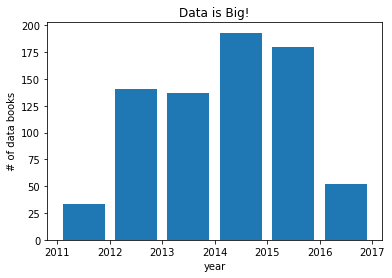

In [35]:
plot_years(plt, books)